In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [8]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///../Resources/hawaii.sqlite")

In [9]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(autoload_with=engine)


In [10]:
# View all of the classes that automap found
Base.classes.keys()


['measurement', 'station']

In [11]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [12]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [16]:
# Find the most recent date in the data set.
most_recent_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()[0]
print(most_recent_date)

2017-08-23


In [17]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database.

# Convert the most recent date to a datetime object
most_recent_date = dt.datetime.strptime(most_recent_date, '%Y-%m-%d')

# Calculate the date one year from the last date in data set.
one_year_ago = most_recent_date - dt.timedelta(days=365)
print(one_year_ago)

2016-08-23 00:00:00


In [20]:
# Perform a query to retrieve the data and precipitation scores
results = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date >= one_year_ago).\
    filter(Measurement.date <= most_recent_date).all()

# Save the query results as a Pandas DataFrame. Explicitly set the column names
df_precip = pd.DataFrame(results, columns=['Date', 'Precipitation'])

# Sort the dataframe by date
df_precip = df_precip.sort_values(by='Date')
print(df_precip)

            Date  Precipitation
0     2016-08-24           0.08
1006  2016-08-24            NaN
1524  2016-08-24           2.15
702   2016-08-24           2.28
360   2016-08-24           2.15
...          ...            ...
1522  2017-08-22           0.00
1523  2017-08-23           0.08
359   2017-08-23           0.00
1005  2017-08-23           0.00
2222  2017-08-23           0.45

[2223 rows x 2 columns]


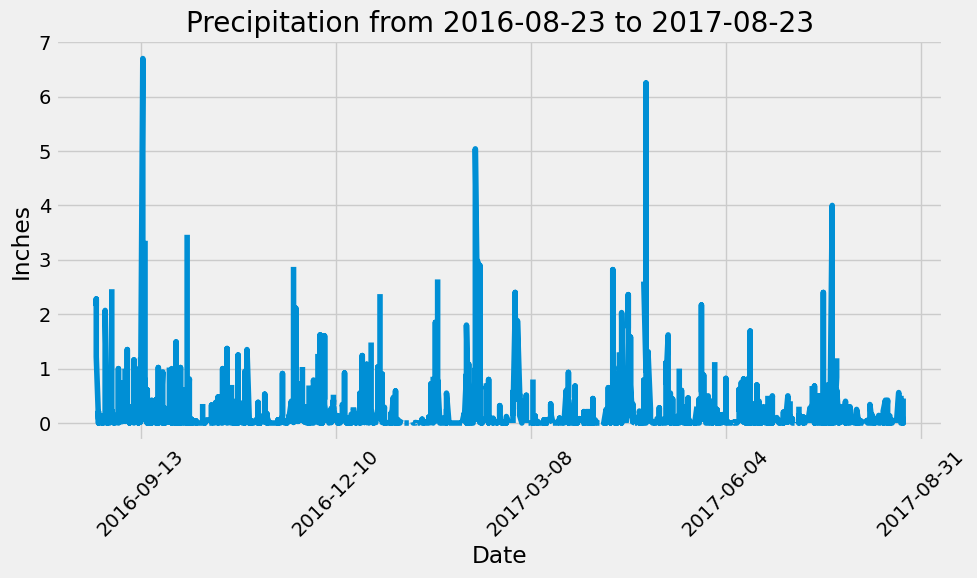

In [40]:
# Use Pandas Plotting with Matplotlib to plot the data
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

plt.figure(figsize=(10, 6))
plt.plot(df_precip['Date'], df_precip['Precipitation'])
plt.title(f"Precipitation from {one_year_ago.strftime('%Y-%m-%d')} to {most_recent_date.strftime('%Y-%m-%d')}")
plt.xlabel('Date')
plt.ylabel('Inches')
plt.xticks(rotation=45)

# Set the locator for the x-axis to show only 5 dates
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=len(df_precip)//25))

# Format the date on the x-axis
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

plt.tight_layout()
plt.show()

In [59]:
# Use Pandas to calculate the summary statistics for the precipitation data
df = pd.read_csv('../Resources/hawaii_measurements.csv')

summary_stats = df['prcp'].describe()
summary_stats = summary_stats.rename('Precipitation')
print(summary_stats.to_markdown(numalign="left", stralign="left"))


|       | Precipitation   |
|:------|:----------------|
| count | 18103           |
| mean  | 0.160644        |
| std   | 0.468746        |
| min   | 0               |
| 25%   | 0               |
| 50%   | 0.01            |
| 75%   | 0.11            |
| max   | 11.53           |


# Exploratory Station Analysis

In [61]:
# Design a query to calculate the total number of stations in the dataset
total_stations = session.query(Station.station).count()
print(total_stations)

9


In [64]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
most_active_stations = session.query(Measurement.station, func.count(Measurement.station)).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.station).desc()).all()

for station, count in most_active_stations:
    print(f"{station}, {count}")

USC00519281, 2772
USC00519397, 2724
USC00513117, 2709
USC00519523, 2669
USC00516128, 2612
USC00514830, 2202
USC00511918, 1979
USC00517948, 1372
USC00518838, 511


In [66]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
most_active_station = session.query(Measurement.station).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.station).desc()).\
    first()

most_active_station_id = most_active_station[0]

# Query the lowest, highest, and average temperatures for the most active station
temperature_stats = session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)).\
    filter(Measurement.station == most_active_station_id).all()

# Extract the temperature statistics
lowest_temp, highest_temp, avg_temp = temperature_stats[0]

# Print the temperature statistics
print(f"{lowest_temp}, {highest_temp}, {avg_temp}")

54.0, 85.0, 71.66378066378067


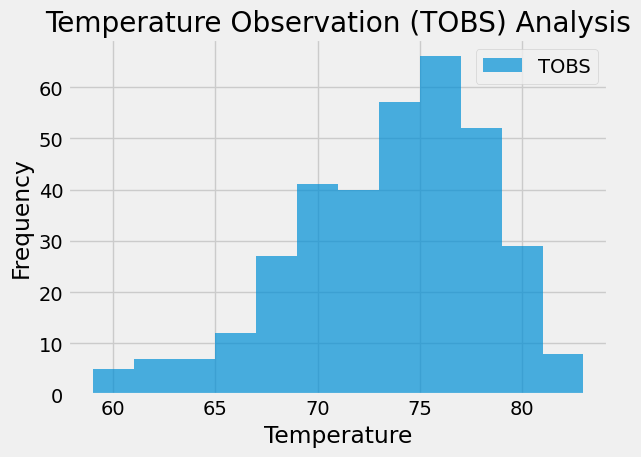

In [71]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
most_active_station = session.query(Measurement.station, func.count(Measurement.station)).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.station).desc()).\
    first().station

# Calculate the date one year ago from the last date in the dataset
one_year_ago = most_recent_date - dt.timedelta(days=365)

tobs_data = session.query(Measurement.tobs).\
    filter(Measurement.station == most_active_station).\
    filter(Measurement.date >= one_year_ago).\
    filter(Measurement.date <= most_recent_date).\
    all()

tobs_list = [result[0] for result in tobs_data]

plt.hist(tobs_list, bins=12, label='TOBS', alpha=0.7)
plt.xlabel('Temperature')
plt.ylabel('Frequency')
plt.title('Temperature Observation (TOBS) Analysis')
plt.legend()
plt.tight_layout()
plt.show()

# Close Session

In [72]:
# Close Session
session.close()